# 1 - Trying Hough Transform

## 1.1 Straight Line
following: https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

In the following example, we construct an image with a line intersection

The Hough transform constructs a histogram array representing the parameter space, i.e. an $MxN$ matrix representing the entries for the values of the two dimensional parameters to describe a line $(m,b)$, but conveniently are used $(\theta, r)$ -> (point angle with x-axis, distance to origin of the point). For each parameter combination $(\theta, r)$ we then find the number of non-zero pixels in the input image that would fall close to the corresponding line and increment the array at position $(\theta, r)$ appropriately.

We can think of each non-zero pixel “voting” for potential line candidates. The local maxima in the resulting histogram indicates the parameters of the most probable lines.

Another approach is the Progressive Probabilistic Hough Transform. It is based on the assumption that using a random subset of voting points give a good approximation to the actual result, and that lines can be extracted during the voting process by walking along connected components. This returns the beginning and end of each line segment, which is useful.

### 1.1.1 Code for clasical Hough transform:

In [12]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage import data

import matplotlib.pyplot as plt
from matplotlib import cm

In [13]:
# Constructing test image: 3 lines
image = np.zeros((200, 200))
idx = np.arange(25, 175)
#Diagonal
image[idx, idx] = 255

#line1
rr_1, cc_1 = draw_line(45, 25, 25, 175)
image[rr_1, cc_1] = 255

#line2
rr_2, cc_2 = draw_line(25, 135, 175, 155)
image[rr_2, cc_2] = 255

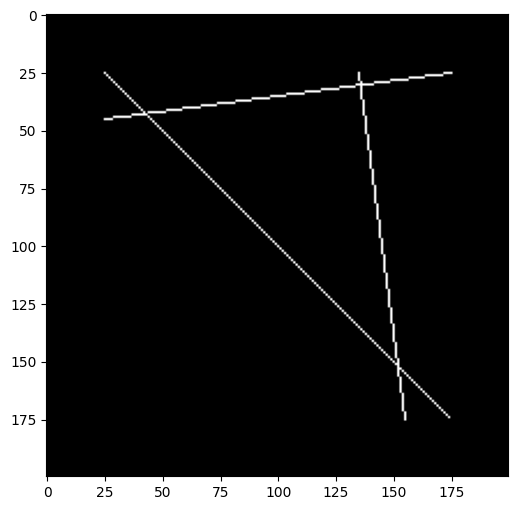

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(image, cmap = cm.gray)

In [15]:
# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)  #(input image, interval to find parameters)

$\textbf{hough_line function:}$

Input: $\text{(image:(M, N) ndarray, theta: 1D ndarray of double, optional. Angles at which to compute the transform, in radians. Default = [pi/2,pi/2])}$

Returns: $\text{(hspace: 2D ndarray Hough transform accumulator, angles: Angles at which the transform is computed, in radians, distances: ndarray. Distance values)}$

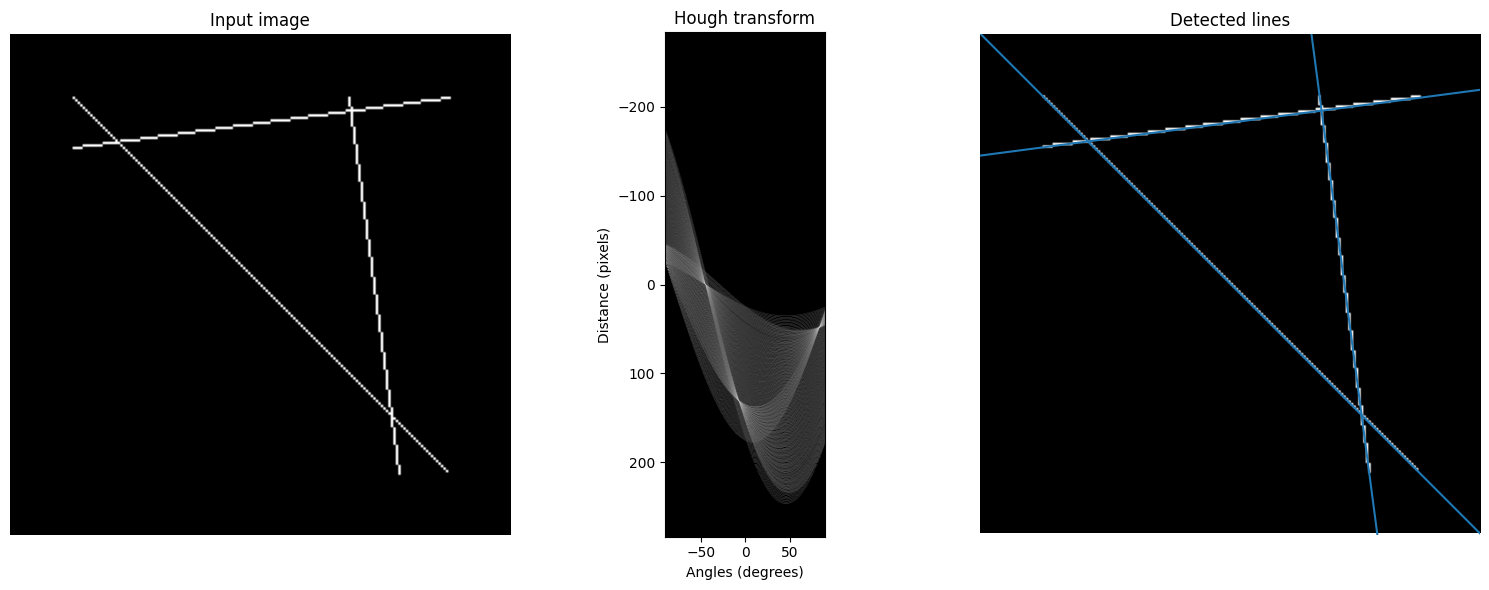

In [16]:
# Generating figure 1
#3 axes generating
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()

#Bounds to give to imshow function(extent = bounds):
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')


#design the reconstructed lines from Hough space paramenters
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

plt.tight_layout()
plt.show()

#### Lets see the peaks in the parameter space

In [17]:
h, theta, d = hough_line(image, theta=tested_angles)

#use the returns of hough_line functions to find the peaks values of the 3 straight lines
accum, angles, dists = hough_line_peaks(h, theta, d)
print('accumulated values:', accum)
print('approx. angles:', angles)
print('approx. distances:', dists)

accumulated values: [150 114 106]
approx. angles: [-0.78539816  1.43989663 -0.13089969]
approx. distances: [  0.  48. 131.]


In [18]:
type(image)

numpy.ndarray

#### Lets plot this

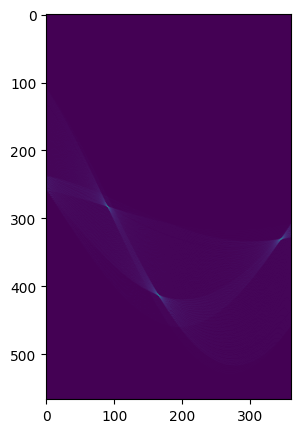

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(h)

### 1.1.2 Code for Probabilistic Hough transform:

more info: https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.probabilistic_hough_line

In [73]:
from skimage.transform import probabilistic_hough_line

# Line finding using the Probabilistic Hough Transform
image = data.camera()
edges = canny(image, 2, 1, 25)
lines = probabilistic_hough_line(edges, threshold=10, line_length=5, line_gap=3)

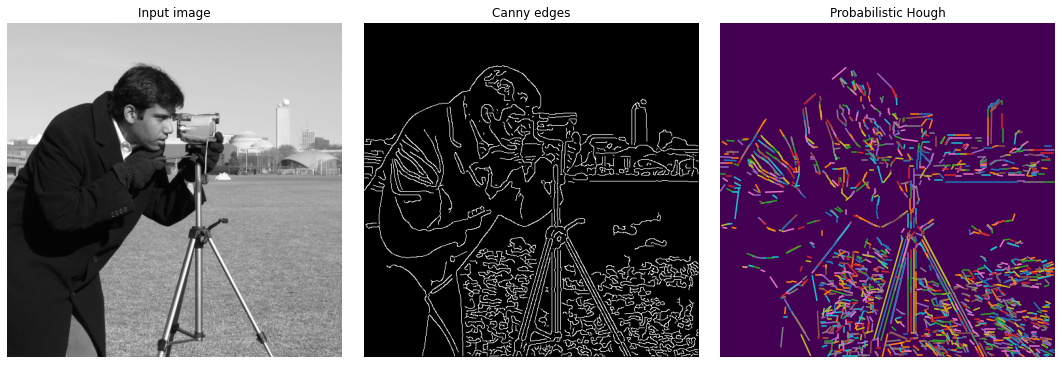

In [81]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

#1st image
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')

#2nd image
ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    #p0, p1 = ((x0,y0),(x1,y1)) = init and end of lines
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## 1.1 Circular and Elliptical Hough Transforms

more info : https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html#circular-and-elliptical-hough-transforms

The Hough transform in its simplest form is a method to detect straight lines but it can also be used to detect circles or ellipses. The algorithm assumes that the edge is detected and it is robust against noise or missing points.

### 1.1.1 Circle detection

In the following example, the Hough transform is used to detect coin positions and match their edges.
We provide a range of plausible radii. For each radius, two circles are extracted and we finally keep the five most prominent candidates. The result shows that coin positions are well-detected.

Given a black circle on a white background, we first guess its radius (or a range of radii) to construct a new circle. This circle is applied on each black pixel of the original picture and the coordinates of this circle are voting in an accumulator. From this geometrical construction, the original circle center position receives the highest score. Note that the accumulator size is built to be larger than the original picture in order to detect centers outside the frame. Its size is extended by two times the larger radius.

In [18]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

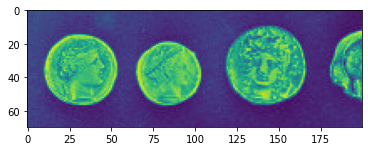

In [19]:
# Load picture and detect edges
image = img_as_ubyte(data.coins()[160:230, 70:270])
edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)

plt.imshow(image)

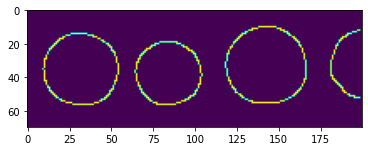

In [20]:
plt.imshow(edges)

In [21]:
edges

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

canny is a function to filttering edges of an image using canny algorithm. more info: https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

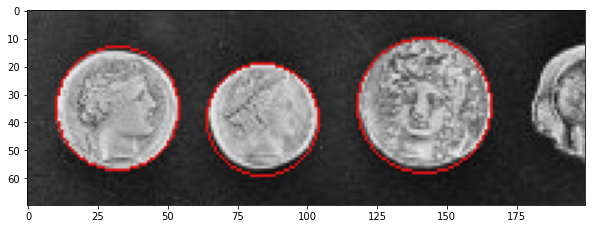

In [22]:
# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(edges, hough_radii) # receive the circel image and the radius and returns the Hough transform accumulator for each radius.

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks = 3)

# hough_circle_peaks receives the Hough transform accumulator, the radii of Hough spcaces. Returns the most probable center and radi values.

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    #What it means??! (220,20,20)? 
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

#Fits well!

### 1.1.2 Ellipse Detection

In this second example, the aim is to detect the edge of a coffee cup. Basically, this is a projection of a circle, i.e. an ellipse. The problem to solve is much more difficult because five parameters have to be determined, instead of three for circles.

The algorithm takes two different points belonging to the ellipse. It assumes that it is the main axis. A loop on all the other points determines how much an ellipse passes to them. A good match corresponds to high accumulator values.

In [23]:
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

In [24]:
# Load picture, convert to grayscale and detect edges
image_rgb = data.coffee()[0:220, 160:420]
image_gray = color.rgb2gray(image_rgb)
edges = canny(image_gray, sigma=2.0,low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis.
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators

result = hough_ellipse(edges, accuracy=20, threshold=250, min_size=100, max_size=120)

In [25]:
result

array([(253, 112.5, 130. , 116.6190379, 94.2669083 , 1.69844078),
       (270, 112.5, 130. , 116.6190379, 94.14483523, 1.68790507),
       (276, 112.5, 130.5, 116.6190379, 94.20456465, 1.69317634),
       (281, 112.5, 130.5, 116.6190379, 94.08772502, 1.68262726),
       (252, 112. , 130. , 116.6190379, 94.42986816, 1.66625004),
       (260, 112. , 130.5, 116.6190379, 94.47883361, 1.67151816),
       (274, 112.5, 130.5, 116.6190379, 94.88150505, 1.66050202)],
      dtype=[('accumulator', '<i8'), ('yc', '<f8'), ('xc', '<f8'), ('a', '<f8'), ('b', '<f8'), ('orientation', '<f8')])

<ipython-input-55-fbe67436599e>:12: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  edges = color.gray2rgb(img_as_ubyte(edges))


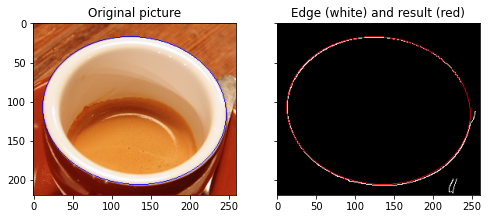

In [55]:
result.sort(order = 'accumulator') #ordering respect to accumulator value

# Estimated parameters for the ellipse
best = list(result[-1]) #Takes the major accumulator
yc, xc, a, b = (int(round(x)) for x in best[1:5]) #iterate over best[1:5]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                sharex=True, sharey=True)
ax1.set_title('Original picture')
ax1.imshow(image_rgb)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()